### Install `mmk` and its dependencies

In [ ]:
!git clone https://github.com/antoinedaurat/mmk.git
!pip install -r mmk/requirements.txt

### load the api token of your neptune account

In [ ]:
from getpass import getpass
api_token = getpass('Enter your private Neptune API token: ')

In [1]:
%cd ../..

/home/antoine/Gdrive/Autoencoders


### Imports

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import IPython.display as ipd
plt.rcParams['figure.figsize'] = (20, 6)
import torch
import numpy as np
import os

# class defining the class of FreqNet models and the dictionary to subclass it
from mmk.models.freqnet import FreqNet, layer_funcs

# generate function 
from mmk.modules.generate import generate

# data utils
from mmk.data import Database

# debug, interact
from mmk.utils import show, audio

### download some data and load it here

In [3]:
db_name = "gould.h5"
# download_database(api_token, project_name="k-tonal/data", experiment_id="DAT-1", database_name=db_name)
db = Database(db_name)
db.metadata

,start,stop,duration,name
0,0,4190,4190,"gould/07 Invention 14 in B-flat major, BWV 785"
1,4190,12541,8351,"gould/26 Sinfonia 4 in D minor, BWV 790"
2,12541,16485,3944,"gould/16 Sinfonia 7 in E minor, BWV 793"
3,16485,19451,2966,"gould/08 Sinfonia 14 in B-flat major, BWV 800"
4,19451,22971,3520,"gould/05 Invention 5 in E-flat major, BWV 776"
5,22971,25310,2339,"gould/09 Invention 11 in G minor, BWV 782"
6,25310,29202,3892,"gould/01 Invention 1 in C major, BWV 772"
7,29202,37210,8008,"gould/06 Sinfonia 5 in E-flat major, BWV 791"
8,37210,39439,2229,"gould/13 Invention 15 in B minor, BWV 786"
9,39439,46676,7237,"gould/29 Invention 9 in F minor, BWV 780"


# Model's Definition and Training

## FreqNet's Parameters :

### Layer Functions

`FreqNet` is, similar to Wavenet, a model with stacked dilated convolution layer. The layer function of FreqNet allows you to specify different options for the implemententation of those stacked dilated convolution layers that result in models with different properties.

Options are :
- `strict` can be `True` or `False`. It specifies whether each layer is to be defined as an autoregressive function or not. Originally, Wavenet considers the whole network to be such a function. Accordingly, for an input of the length of wavenet's receptive-field, wavenet outputs a single (future) time-step. Setting `strict` to `True`, makes each layer outputs a (future) time-step, which results in an output of `#of-layers` time-steps for an input with length equal to the receptive-field. 
- `accum_outputs` adds residual to the layer's definition. Possible values are `[-1, 0, 1]` for residuals aligned to the left, no residuals, and residuals aligned to the right respectively.
- `concat_outputs` also takes `[-1, 0, 1]` as possible values for left-, None and right-concatenation respectively. Since convolution layers outputs fewer time-steps then they recieve, this option concatenates some of the input (left or right) to make the output of the layer have the same length as the input.
- `pad_input` also takes `[-1, 0, 1]` as possible values for left-, None and right-padding of the input.

`layer_funcs` is a `dict` holding pre-defined layer functions. Just take a look at this object to see some possible combinations of these options.


### Other Parameters

- `database` must be the `Database` object holding the data you want to use for training.
- `train_set` must be a `pandas.DataFrame` specifying some subset of the data.
- `gate_c`, `residuals_c` and `skips_c` are the number of channels to use for each of this convolutions
- `conv_kwargs` is a `dict` of parameters for the `torch.nn.Conv1d` objects.
- `lf` is the layer_function. It should be a `partial` packed in a tuple (otherwise it mysteriously disappear from the hyperparameters...)
- `layers` is a tuple of integers. Each integers `k` defines a block of `k` layers that will have `2**k` time-steps in its receptive-field.
- `learn_padding` lets you make the input padding learnable whenever you use `pad-input` in the layer-function.
- `lr` is the max learning rate. Values between 1e-3 and 1e-4 work in most cases.
- `batch_size` and `sequence_length` lets you specify `N` and `S` for batches of shape `(N x S x D)` aka (number of sequences, number of steps per sequence, time-step dimensionality)
- `root_dir`, `name` and `version` specify where to store the model files. The path to all the files will be `root_dir/name/version`. If you don't specify a `version` and `overwrite` is `False` a new folder is added in `root_dir/name`
- `era_duration` is the frequency at which you want to make training checkpoints. `era_duration=50` means you'll have one checkpoint every 50 epochs. 

In [13]:
from mmk.kit import get_trainer

fnet = FreqNet(
    # data :
    inputs=db.fft.get(db.metadata.iloc[[0, ]]),
    data_args=dict(
        batch_size=64,
        sequence_length=64,
        to_gpu=True,
        splits=[.8, .2],
    ),
    
    # model architecture
    model_args=dict(
        model_dim=1024,
        conv_kwargs=dict(groups=1),
        lf=layer_funcs["strict_recursive"],
        layers=(int(np.log2(8)),),
        layer_wise_loss=True,
        learn_padding=False,),
    
    # training
    optim_args=dict(
        max_lr=7e-4,
        betas=(0.9, 0.9),
        max_epochs=100,
    )
)

trainer = get_trainer(
    root_dir="freqnet_test", 
    version=0,
    epochs=[10,]
)

trainer.fit(fnet)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/antoine/anaconda3/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping validation loop
  warnings.warn(*args, **kwargs)

  | Name   | Type             | Params
--------------------------------------------
0 | inpt   | GatedLinearInput | 2.1 M 
1 | blocks | ModuleList       | 18.9 M
2 | outpt  | AbsLinearOutput  | 1.1 M 


Checkpoints and logs will be saved in /home/antoine/Gdrive/Autoencoders/freqnet_test/version_0


/home/antoine/anaconda3/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 0 - loss : 88.7071 
Epoch 1 - loss : 78.9893 
Epoch 2 - loss : 70.6917 


/home/antoine/anaconda3/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)



Training finished after 0 days 0 hours 0 mins 53 seconds


1

In [5]:
fnet.layers_shifts, fnet.layers, fnet.shift

(((0, 2, 5, 10, 20),), (4,), 20)

### upload your model to neptune

In [ ]:
upload_model(fnet, api_token, "k-tonal/model-upload-test")

### Either load a checkpoint ...

In [ ]:
root_dir="mmk_test_model/"
name="mmk_test_model"
version = str(0)
epoch = None

# load the checkpoint
fnet = FreqNet.load(FreqNet, root_dir + name + "/v" + version + "/", epoch)

### ... or download a model from neptune

In [ ]:
epoch = None
model_path  = download_model(api_token,
                             project_name="k-tonal/model-upload-test",
                             experiment_id="MOD-2")
fnet = FreqNet.load(FreqNet, model_path, epoch)

## Generate

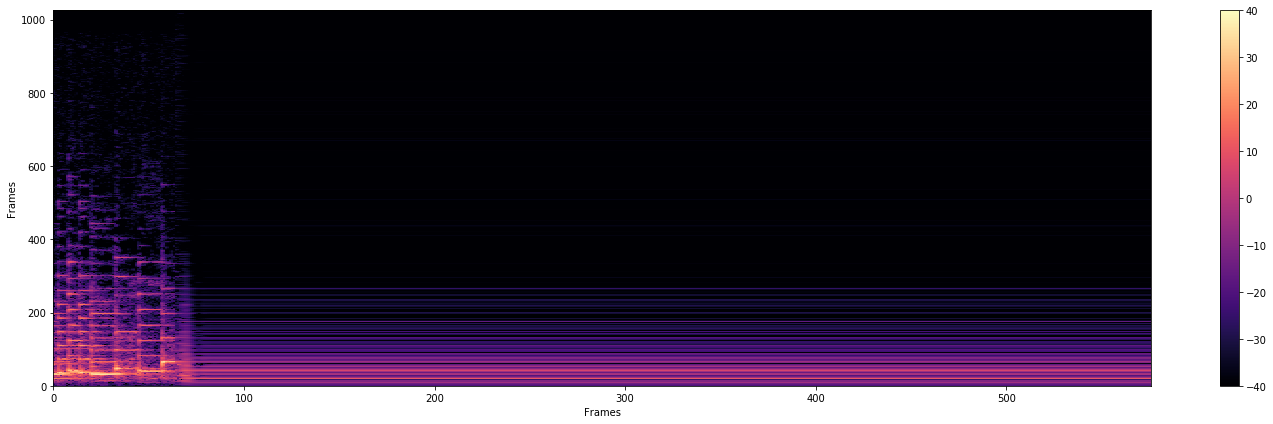

In [12]:
input_length = 64
n_steps = 512
# pick a random input slice from the trainset
piece = db.metadata.iloc[[0, ]].sample(1)
input_start = np.random.randint(piece.start.min(), piece.stop.max(), 1)[0]

inpt = db.fft[input_start:input_start+input_length]

if torch.cuda.is_available():
    fnet.to("cuda")

generated = generate(fnet.eval(), inpt, n_steps, *fnet.generation_slices())

audio(generated.T)
show(generated.T)

### Plot the latent variables (skips) for each layer

In [ ]:
from mmk.utils import numcpu, to_torch

fnet = fnet.to("cuda").eval()
inpt, target = next(iter(fnet.dl))

# helper func
permute = lambda x: x.transpose(1, 2).contiguous()

# modify the forward method to collect the latents
with torch.no_grad():
    latents = []
    x = inpt.clone()
    x = fnet.inpt(x)
    latents += [permute(x.clone())]
    skips = None
    block = fnet.blocks[0]
    for layer in block.block:
        x, skips = block.layer_func(layer, x, skips)
        latents += [permute(skips.clone())]
    y = fnet.outpt(skips)
    
inpt = numcpu(inpt[0].squeeze()).T
plt.figure()
show(inpt, db_scale=True, title="input")
print("input:")
audio(inpt)

latents = [numcpu(h[0].squeeze()).T for h in latents]

for i, h in enumerate(latents):
    plt.figure()
    show(h, db_scale=False, title="latent_" + str(i))

    
y = numcpu(y[0].squeeze()).T
plt.figure()
show(y, title="output")
print("output:")
audio(y)

    
target = numcpu(target[0].squeeze()).T[:, :y.shape[1]]
plt.figure()
show(target, title="target")
print("target:")
audio(target)

In [ ]:
plt.plot(latents[1][:, [38,13]])

In [ ]:
X = latents[3]
cov = np.zeros((512, 512))
for t in range(X.shape[1]-1):
    cov += np.cov(X[:, [t, t+1]])
    
show(cov, db_scale=False)
plt.figure()
show(np.cov(X), db_scale=False)

In [ ]:
Wf = numcpu(fnet.inpt.fcg.weight.detach().T)
Wg = numcpu(fnet.inpt.fcf.weight.detach().T)

show(Wf, db_scale=False, title="filter components")
plt.figure()
show(Wg, db_scale=False, title="gate components")

In [ ]:
plt.plot(np.linalg.norm(Wf, axis=0))
plt.plot(np.linalg.norm(Wg, axis=0))